In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt
from matplotlib.ticker import MultipleLocator
from obspy import read, read_inventory
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
model = TauPyModel(model="iasp91")
client = Client("IRIS")

In [3]:
starttime = UTCDateTime("2013-01-01")
endtime = UTCDateTime("2015-12-31")
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=6,latitude =41.115,longitude=43.8036,
                        minradius=65,maxradius=155)#,mindepth=100)
print(cat)

417 Event(s) in Catalog:
2015-12-20T18:47:36.610000Z |  +3.646, +117.636 | 6.1 mww
2015-12-19T02:10:53.360000Z | -18.382, +169.386 | 6.0 mww
...
2013-01-15T16:09:37.750000Z | -62.509, -161.276 | 6.1 MW
2013-01-05T08:58:19.180000Z | +55.235, -134.801 | 7.5 MW
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [4]:
freqmin = 0.04
freqmax = 0.125
FIG_DIR = f'/Volumes/home/Research/Progress/00_GO_record_plot_ZRT_{freqmin}-{freqmax}'
if not os.path.isdir(FIG_DIR):
    os.mkdir(FIG_DIR)
Zphase = ['P','PcP','PP','PKP', 'PKIKP', 'PKiKP', 'Pdiff', 'PKKP', 'PPP', 'ScP', 'SP', 'PS' ,'PcS' ,'SKP' ,'PKS' ]
Rphase = ['S','Sdiff', 'SS' ,'SSS' ,'SSSS' ,'SKS' ,'SKKS' ,'SKKKS' ,'ScP' ,'SP' ,'PS' ,'PcS','SKP','PKS' ]
Tphase = ['S','Sdiff','SS','SSS','SSSS','ScS']
phaselist = set(Zphase + Rphase + Tphase)
EVILSTA=['SEAG','KZRT','BATM','BGD','DGRG']
GOODSTA=['ONI','AKH']

mmm = 10**-4
exg = 2
arr_size=25

2015-12-20T18:47:36.610000Z
 GO AKH pass
 GO BATM pass
 GO BGD pass
 GO CHVG pass
 GO DDFL pass
 GO DGRG pass
 GO GUDG pass
 GO KZRT pass
 GO LGD pass
GO ONI
 GO SEAG pass
 GO TBLG pass
 GO TRLG pass
IU GNI
II KIV
=============================align with P
==========================figure save


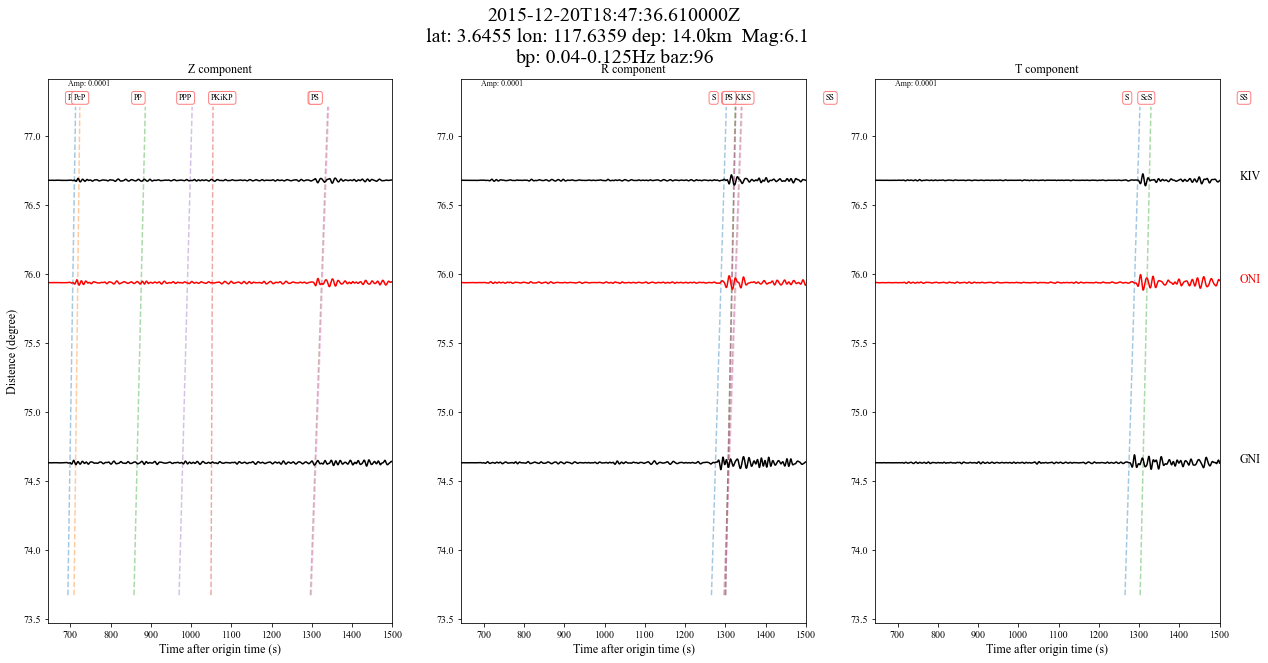

In [12]:
for cata in cat[0:1]:
    plt.figure(1,figsize=(21,10))
    
    plt.rcParams['font.sans-serif']='Times New Roman'
    eq_time = cata.origins[0].time
    print(eq_time)
    eq_lon = cata.origins[0].longitude
    eq_lat = cata.origins[0].latitude
    depth  = cata.origins[0].depth/1000
    mag    = cata.magnitudes[0].mag
    mag_type = cata.magnitudes[0].magnitude_type
    
    inv  = client.get_stations(network="GO", station='*', channel="*",
                                    starttime=eq_time,endtime=eq_time+30*60)
    inv1 = client.get_stations(network="IU", station='GNI', channel="*",
                                    starttime=eq_time,endtime=eq_time+30*60)
    inv2 = client.get_stations(network="II", station='KIV', channel="*",
                                    starttime=eq_time,endtime=eq_time+30*60)
    inv = inv + inv1 + inv2
    deglist = []; STAlist = []; BAZlist = []
    for net_i in inv:
        NET = net_i.code
        for sta_i in net_i:
            STA = sta_i.code
            st_lat = sta_i.latitude
            st_lon = sta_i.longitude
            
            dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
            dist = dist/1000
            deg = kilometer2degrees(dist)
            deglist.append(deg)
            STAlist.append(STA)
            BAZlist.append(baz)
        
##=============calculate traval time=====================
    min_arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=min(deglist),phase_list=phaselist)
    for arr in min_arrivals:
        name=arr.phase.name
        if arr.time <1800:
            locals()['min_arr_%s' % (name)]= arr.time
    
    max_arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=max(deglist),phase_list=phaselist)
    for arr in max_arrivals:
        name=arr.phase.name
        if arr.time <1800:       
            locals()['max_arr_%s' % (name)]= arr.time
##=============plot traval time curves=====================    
    plt.figure(1,figsize=(21,10))
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)
    for phase in Zphase:
        try:
            min_arr_t= locals()['min_arr_%s' % (phase)]
            max_arr_t= locals()['max_arr_%s' % (phase)]
            if min_arr_t < 1800:
                ax1.plot([min_arr_t,max_arr_t],[min(deglist)-0.1,max(deglist)+0.1],ls='--',alpha=0.4) 
                ax1.text(min_arr_t,max(deglist)+0.15,phase,c='k',fontsize=8,ma='left',
                         bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc='white'))
        except KeyError: continue  
    for phase in Rphase:
        try:
            min_arr_t= locals()['min_arr_%s' % (phase)]
            max_arr_t= locals()['max_arr_%s' % (phase)]
            if min_arr_t < 1800:
                ax2.plot([min_arr_t,max_arr_t],[min(deglist)-0.1,max(deglist)+0.1],ls='--',alpha=0.4) 
                ax2.text(min_arr_t,max(deglist)+0.15,phase,c='k',fontsize=8,ma='left',
                         bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc='white'))
        except KeyError: continue
    for phase in Tphase:
        try:
            min_arr_t= locals()['min_arr_%s' % (phase)]
            max_arr_t= locals()['max_arr_%s' % (phase)]
            if min_arr_t < 1800:
                ax3.plot([min_arr_t,max_arr_t],[min(deglist)-0.1,max(deglist)+0.1],ls='--',alpha=0.4) 
                ax3.text(min_arr_t,max(deglist)+0.15,phase,c='k',fontsize=8,ma='left',
                bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc='white'))
        except KeyError: continue
##=========================================================
    i=0
    for net_i in inv:
        NET = net_i.code
        for sta_i in net_i:
            STA = sta_i.code
            
            deg = deglist[i]
            baz = BAZlist[i]
            i+=1              
            try:
                st = client.get_waveforms(NET, STA,'*','*',eq_time,eq_time+30*60,attach_response=True)
                print(NET,STA)
                st.merge(fill_value=0)
                if NET == "II" or NET == 'IU':
                    prefilt=[0.001,0.005,9,10]
                else : prefilt = [0.001, 0.005, 45, 50]
                st.remove_response(pre_filt = prefilt, output="DISP")
                st.detrend('linear')
                st.detrend('demean')
                st.taper(0.05,type='cosine')
                st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)
                if NET == 'GO':
                    HHE = st.select(component='E')[0].data
                    HHN = st.select(component='N')[0].data
                    HHZ = st.select(component='Z')[0].data
                    HHR,HHT = rotate_ne_rt(HHN,HHE,baz)
                elif NET == 'IU' or NET == 'II' :
                    HH2 = st.select(location='00', channel='BH2')[0].data
                    HH1 = st.select(location='00', channel='BH1')[0].data
                    HHZ = st.select(location='00', channel='BHZ')[0].data
                    HHR,HHT = rotate_ne_rt(HH1,HH2,baz)
                
                times= st[0].times()
                
                HHZ=HHZ/mmm
                HHR=HHR/mmm
                HHT=HHT/mmm

                if STA in GOODSTA: color = 'r'
                else : color='k'
                

                ax1.set_title('Z component',fontsize=12)
                ax1.plot(times,HHZ*exg+deg,lw=1.5,color=color)
                ax1.set_xlabel('Time after origin time (s)',fontsize=12)
                ax1.set_ylabel('Distence (degree)',fontsize=12)
                ax1.set_ylim(min(deglist)-0.3,max(deglist)+0.3)

                ax2.set_title('R component',fontsize=12)
                ax2.plot(times,HHR*exg+deg,lw=1.5,color=color)
                ax2.set_xlabel('Time after origin time (s)',fontsize=12)
                ax2.set_ylim(min(deglist)-0.3,max(deglist)+0.3)

                ax3.set_title('T component',fontsize=12)
                ax3.plot(times,HHT*exg+deg,lw=1.5,color=color)
                ax3.set_xlabel('Time after origin time (s)',fontsize=12)
                ax3.set_ylim(min(deglist)-0.3,max(deglist)+0.3)
                if min(deglist) <=98: STAxloc = 1500
                elif min(deglist) > 98: STAxloc = times[-1]
                ax3.text(STAxloc+50,deg,STA,fontsize=12,color=color)
                plt.suptitle(f'{eq_time}\n lat:{eq_lat} lon:{eq_lon} dep:{depth}km  {mag}{mag_type}\nbp:{freqmin}-{freqmax}Hz', 
                         fontsize=20)

            except: 
                print(f' {NET} {STA} pass')
######========================================    
    if min(deglist) <= 98 and 'min_arr_P' in locals():
        print('=============================align with P')
        ax1.text(min_arr_P,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
        ax2.text(min_arr_P,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
        ax3.text(min_arr_P,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)

        ax1.set_xlim(min_arr_P-50,1500)#times[-1])
        ax2.set_xlim(min_arr_P-50,1500)#times[-1])
        ax3.set_xlim(min_arr_P-50,1500)#times[-1])
    elif min(deglist) > 98 and 'min_arr_Pdiff' in locals():
        print('=============================align with Pdiff')
        ax1.text(min_arr_Pdiff,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
        ax2.text(min_arr_Pdiff,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
        ax3.text(min_arr_Pdiff,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)

        ax1.set_xlim(min_arr_Pdiff-50,times[-1])
        ax2.set_xlim(min_arr_Pdiff-50,times[-1])
        ax3.set_xlim(min_arr_Pdiff-50,times[-1])
    else : 
        ax1.text(950,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
        ax2.text(950,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
        ax3.text(950,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)

        ax1.set_xlim(950,times[-1])
        ax2.set_xlim(950,times[-1])
        ax3.set_xlim(950,times[-1])
    plt.suptitle(f'{eq_time}\n lat: {eq_lat} lon: {eq_lon} dep: {depth}km  Mag:{mag}\nbp: {freqmin}-{freqmax}Hz baz:{int(min(BAZlist))}', 
                 fontsize=20)
    
#     plt.savefig(f'{FIG_DIR}/{eq_time}.png',dpi=200,facecolor='white')
    print('==========================figure save')
#     plt.close()

#######==============變數刪除================    
    for arr in min_arrivals:
        name=arr.phase.name
        var = 'min_arr_'+name
        if var in locals():
            del locals()['min_arr_%s' % (name)]
    for arr in max_arrivals:
        name=arr.phase.name
        var = 'max_arr_'+name
        if var in locals():
            del locals()['max_arr_%s' % (name)] 